# Basic description of the data sets
Data comes from http://stat-computing.org/dataexpo/2009/the-data.html.
* Variable descriptions are also shown at that url.
* As shown below, there are 7453215 observations of 29 variables.
* All variable names can be seen below.
* The dataset has 304 unique departure airports and 310 unique destination airports (relatively few?).

In [1]:
## US airports data# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

## US domestic flights data, cleaned

In [2]:
FlightsNx = pd.read_pickle("FlightsNx18.pkl")
print('Rows:', len(FlightsNx.index))
print(FlightsNx.columns)
print('There are {} unique departure airports in the dataset'.format(FlightsNx.Origin.nunique()))
print('There are {} unique destination airports in the dataset'.format(FlightsNx.Dest.nunique()))
FlightsNx["Journey"] = FlightsNx["Origin"]+FlightsNx["Dest"]
print('There are {} unique journeys in the dataset'.format(FlightsNx.Journey.nunique()))

Rows: 6425
Index(['Origin', 'Dest', 'Distance', 'count', 'avg_time_mins', 'companies',
       'Origin_flights', 'Destination_flights', 'origin_degree', 'dest_degree',
       'origin_btwns', 'dest_btwns', 'origin_clustcoef', 'dest_clustcoef'],
      dtype='object')
There are 358 unique departure airports in the dataset
There are 358 unique destination airports in the dataset
There are 6365 unique journeys in the dataset


### Using NetworkX

In [3]:
Network = nx.from_pandas_edgelist(FlightsNx, source = "Origin", target = "Dest", edge_attr = True)
print(nx.info(Network))

Name: 
Type: Graph
Number of nodes: 358
Number of edges: 3220
Average degree:  17.9888


### Sparse

In [4]:
# calculate L_max:  
print("L_max = {}".format(len(Network.nodes)*(len(Network.nodes)-1)*(1/2)))
print(2868/47895)

L_max = 63903.0
0.05988098966489195


### Degree distribution

In [5]:
degrees = pd.read_pickle("Degrees.pkl")

In [6]:
print('No. airports w. degree < 5:  ', len(degrees.loc[(degrees["degree_unnormalized"] < 5)].index))
print('No. airports w. degree > 100:', len(degrees.loc[(degrees["degree_unnormalized"] > 100)].index))

# See most connected airports in dataset
degrees.sort_values(by = "degree_unnormalized", ascending = False).head(10)

No. airports w. degree < 5:   120
No. airports w. degree > 100: 9


,degree,degree_unnormalized,airport
70,0.601942,186.0,ATL
72,0.498382,154.0,ORD
111,0.427184,132.0,DFW
77,0.420712,130.0,MSP
28,0.398058,123.0,SLC
54,0.394822,122.0,DEN
65,0.378641,117.0,IAH
79,0.378641,117.0,CVG
18,0.372168,115.0,DTW
67,0.300971,93.0,EWR


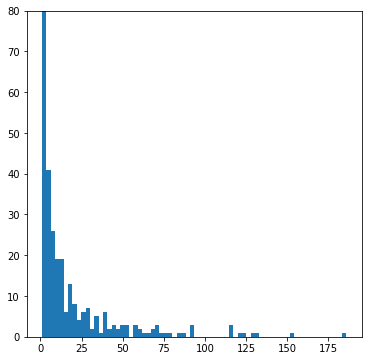

In [7]:
# Degree distribution
fig, ax = plt.subplots(figsize = (6,6))
plt.hist(degrees["degree_unnormalized"], bins = 70)
plt.ylim(0,80)
plt.show()

### Betweenness centrality

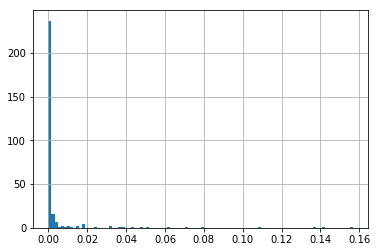

In [8]:
btwn = nx.betweenness_centrality(Network)
betweenness = list(btwn.values())
btwn_df = pd.DataFrame(betweenness)
btwn_df.columns = ["betweenness"]
btwn_df["airport"] = btwn.keys()

btwn_df.sort_values(by = "betweenness", ascending = False)
Node_char = degrees.merge(btwn_df, on= "airport")


Clustering Coefficient

In [22]:
clusters = nx.algorithms.cluster.clustering(Network)
clusters_df = pd.DataFrame(list(clusters.values()))
clusters_df.columns = ["clustering"]
clusters_df["airport"] = clusters.keys()
Node_char = Node_char.merge(clusters_df, on = "airport")

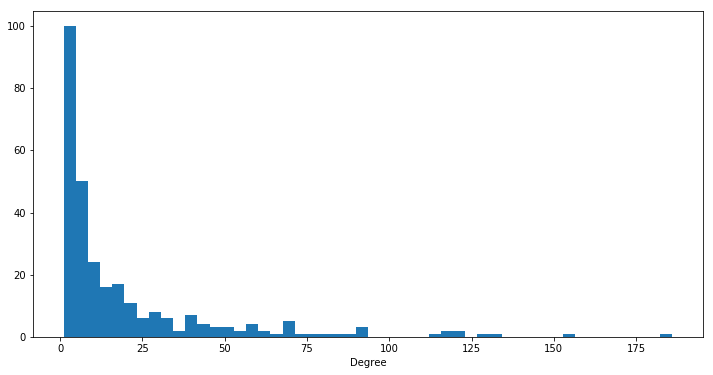

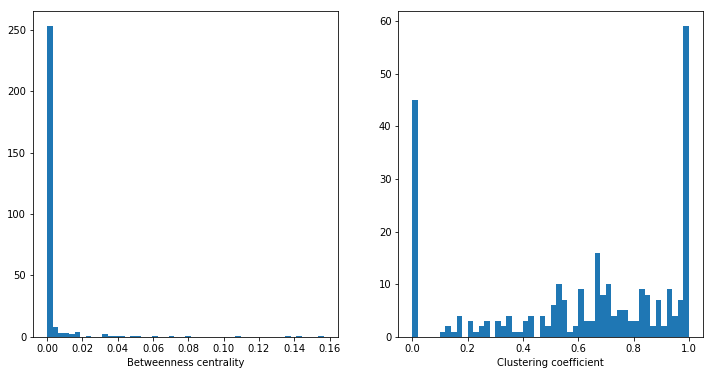

In [33]:
## Figure with degree distribution, betweenness centrality and clustering
fig, ax = plt.subplots(figsize = (12,6))

plt.hist(Node_char["degree_unnormalized"], bins = 50)
plt.xlabel("Degree")
plt.savefig(fname = "Figures/degreeDistribution.png", bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots(figsize = (12,6))

plt.subplot(1,2,1)
plt.hist(Node_char["betweenness"], bins = 50)
plt.xlabel("Betweenness centrality")

plt.subplot(1,2,2)
plt.hist(Node_char["clustering"], bins = 50)
plt.xlabel("Clustering coefficient")
plt.savefig(fname = "Figures/Btwns_CC.png", bbox_inches = "tight")
plt.show()

#### (node) betweenness centrality vs degree

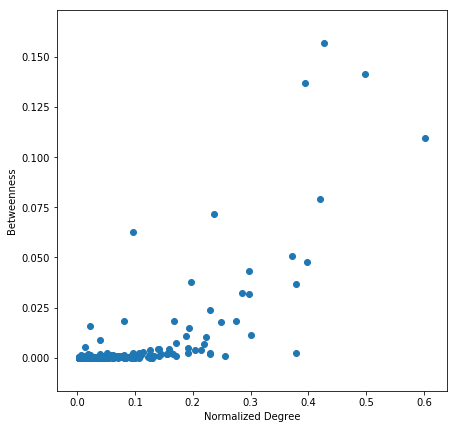

In [9]:
# Betweenness vs. degree
fig, ax = plt.subplots(figsize = (7,7))
plt.scatter(Node_char["degree"],Node_char["betweenness"])
plt.xlabel("Normalized Degree")
plt.ylabel("Betweenness")
plt.show()

### Measures for entire network

In [10]:
# print(nx.info(Network))
print("The average shortest path is: {}".format(nx.average_shortest_path_length(Network)))
print("The average clustering coefficient is: {}".format(nx.average_clustering(Network)))
print("The diameter of the network is: {}".format(nx.diameter(Network)))
print("The global efficiency of the network is: {}".format(nx.global_efficiency(Network)))

The average shortest path is: 2.3794657527815595
The average clustering coefficient is: 0.5671628544291067
The diameter of the network is: 6
The global efficiency of the network is: 0.4571454652628847


### Shortest path length: Atlanta example

In [11]:
avg_shrt_path_len = nx.average_shortest_path_length(Network)
print(avg_shrt_path_len)

2.3794657527815595


## US airports data

In [13]:
Airports = pd.read_pickle("Airports.pkl")

# Get list of nodes, and add lat, lon from Airports dataset:
nodes = pd.DataFrame(list(Network.nodes()))
nodes.columns = ["3DigitId"]
positions = nodes.merge(Airports[["3DigitId","Lat","Lon"]], how = "left", on = "3DigitId")

print('No. airports in the openflights data:', len(Airports))
print('- of which missing 3DigitId:', Airports['3DigitId'].value_counts(dropna=False).nlargest(1)[0])
print('- of which containing 3DigitId:', Airports['3DigitId'].nunique())
print('No. airports within the network:', positions['3DigitId'].nunique())
positions.head(2)

No. airports in the openflights data: 1512
- of which missing 3DigitId: 261
- of which containing 3DigitId: 1252
No. airports within the network: 358


,3DigitId,Lat,Lon
0,FLL,26.072599,-80.152702
1,IAH,29.984400,-95.341400
